In [1]:
from src.memory_game.game import Game
from src.strategy.strategies import BaseStrategy, PerfectMemory, TileMemory, RandomHashMemory, BaseAttractorMemory, CNNAttractorMemory, RandomAttractorMemory, BernoulliMemory, BinaryAttractorMemory
from src.models.cvmodel import CVModel
from src.models.memory import TileRNN, HashRNN, Attractor

from fiftyone import ViewField as F

import math

import torch

import pandas as pd

import numpy as np

import collections, gc, resource

from tqdm import tqdm

import matplotlib.pyplot as plt
import matplotlib.gridspec as grd

import seaborn as sns
sns.set_style(style='white')

torch.no_grad()

In [2]:
print(f'Cuda available: {torch.cuda.is_available()}')
print(f'Cuda device count: {torch.cuda.device_count()}')

Cuda available: True
Cuda device count: 4


In [3]:
device = 1

device = torch.device(f"cuda:{device}")
print(torch.cuda.get_device_name(device))

GeForce RTX 2080 Ti


# Collect data 1 Trial

In [4]:
def play_strategy(strategy, game):
    win = False
    while not win:
        strategy.pick()
        win, tot = game.check_win()
        torch.cuda.empty_cache()
    return tot

In [5]:
def plot_history(locations, category):
    # create a 3 X 2 grid 
    fig = plt.figure(figsize=(24, 10))
    gs = grd.GridSpec(3, 2, figure=fig, height_ratios=[len(locations),len(locations),len(category)], width_ratios=[18,1], wspace=0.4)
    # image plot
    ax1 = plt.subplot(gs[1,0])
    p1 = ax1.imshow(locations, aspect='auto', interpolation='none', cmap='hot')
    colorAx1 = plt.subplot(gs[1,1])
    cb1 = plt.colorbar(p1, cax = colorAx1)
    # image plot
    ax2 = plt.subplot(gs[2,0])
    p2 = ax2.imshow(category, aspect='auto', interpolation='none', cmap='hot')
    colorAx2 = plt.subplot(gs[2,1])
    cb2 = plt.colorbar(p2, cax = colorAx2)
    
    plt.show()

In [6]:
game = Game(
            dataset_name='coco-2017', 
            split='validation', 
            field="ground_truth", 
            ds_filter=F("supercategory").is_in(('person', 'animal', 'food', 'vehicle', 'indoor')),
            dataset_dir ="/home/ravi/datasets/coco-2017",
        )

Found annotations at '/home/ravi/datasets/coco-2017/raw/instances_val2017.json'
Images already downloaded
Existing download of split 'validation' is sufficient
Loading existing dataset 'coco-2017-validation'. To reload from disk, either delete the existing dataset or provide a custom `dataset_name` to use


[1 0 4 3 3 1 2 4 0]
[0 1 2 3 4 5 6 7 8]
12


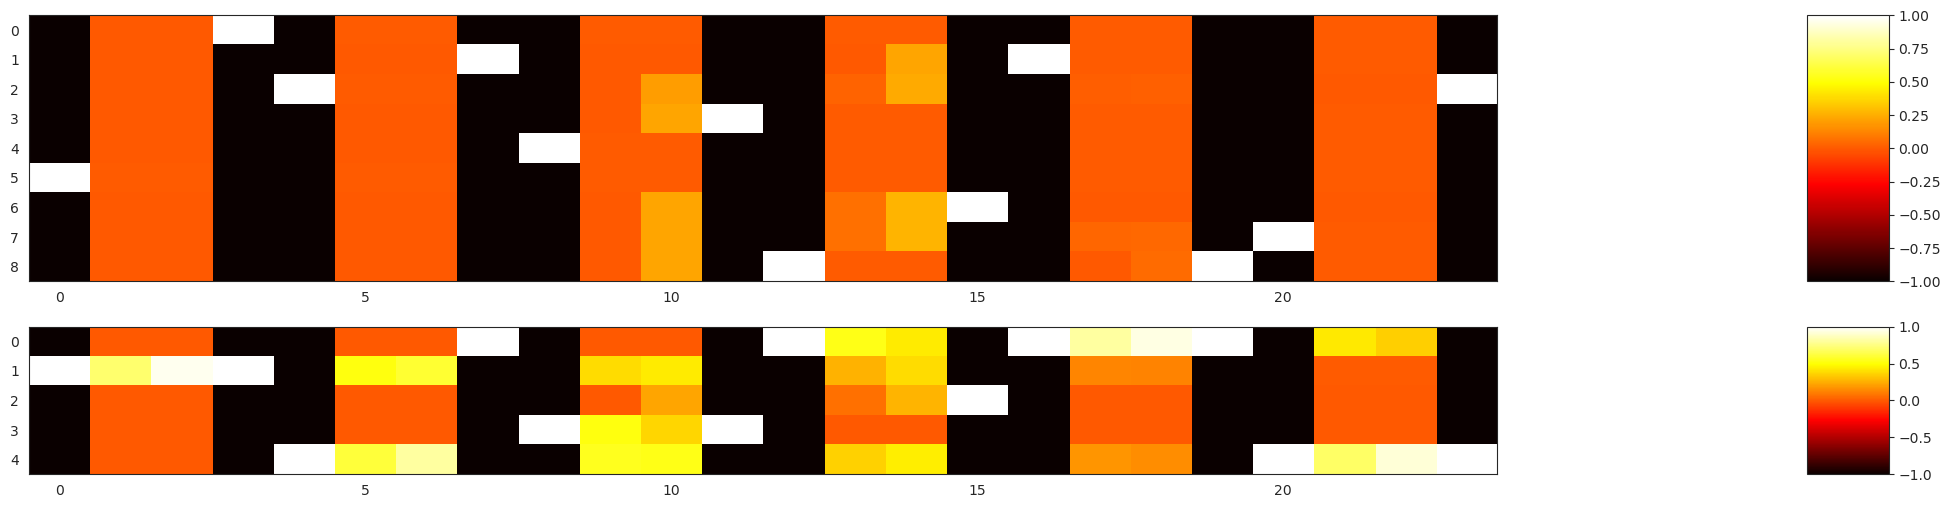

In [7]:
size = [3,3]
game.set_size(size)
pos_f = np.prod(size)
lab_f = len(np.unique(game.get_grid_labels()))
dim = pos_f + lab_f
memory = Attractor(dim, lr=0.3, rr=0.4, decay=0.9, tau=2)
strategy = BaseAttractorMemory(game, memory, np.prod(size), familiar=False)
print(game.get_grid_labels())
print(np.arange(9))
tot = play_strategy(strategy, game)
print(tot)
ah = memory.get_activation_history()
plot_history(ah[:, :pos_f].T, ah[:, pos_f:].T)

it might be that the -1 is making it forget, but this should be compensated by the past memories... might need to fit the behvaioural data directly?